In [103]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Beginning section

In [104]:
def f(x):
    return 3*x**2 - 4*x + 5

In [105]:
f(3)

20

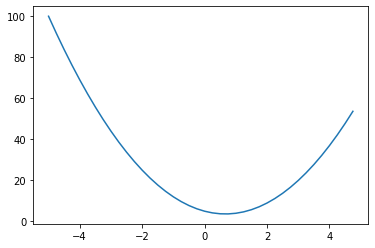

In [106]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [107]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [108]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [109]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


## Critical functions

In [110]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # rank_direction = LR is left to right

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape='record')
        if node._op:
            dot.node(name = uid + node._op, label = node._op)
            dot.edge(uid + node._op, uid)
        
    for src, dst in edges:
        dot.edge(str(id(src)), str(id(dst)) + (dst._op or ''))
    
    return dot

In [111]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), (self,), 'tanh')
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for n in reversed(topo):
            n._backward()

## Manual back-prop testing

In [112]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b;  e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

L

Value(data=-8.0)

In [113]:
d, d._prev, d._op

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)}, '+')

In [114]:
L.grad = 1
d.grad = f.data
f.grad = d.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data

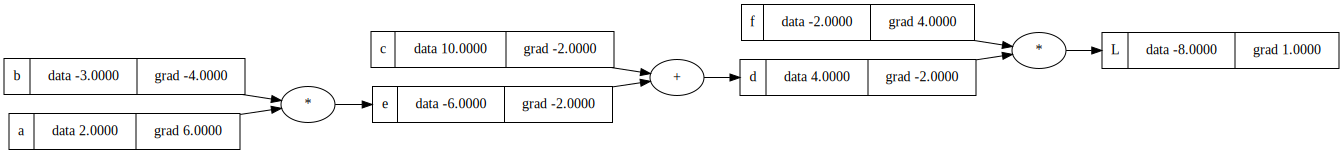

In [115]:
draw_dot(L)

In [116]:
lr = 0.01
leaf_nodes = [a, b, c, f]
for node in leaf_nodes:
    node.data += lr * node.grad

In [117]:
# forward pass
e = a*b
d = e + c
L = d*f

print(L.data)

-7.286496


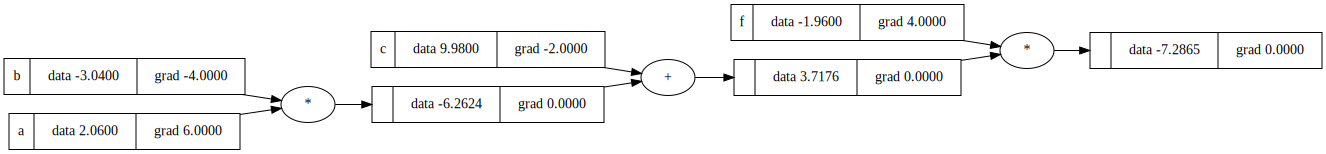

In [118]:
draw_dot(L)

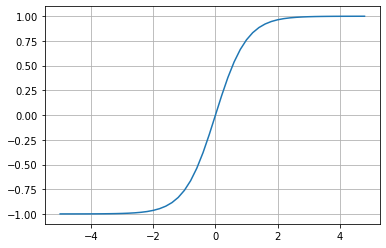

In [120]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

## Auto back-prop

In [121]:
# Let's make a neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 * x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

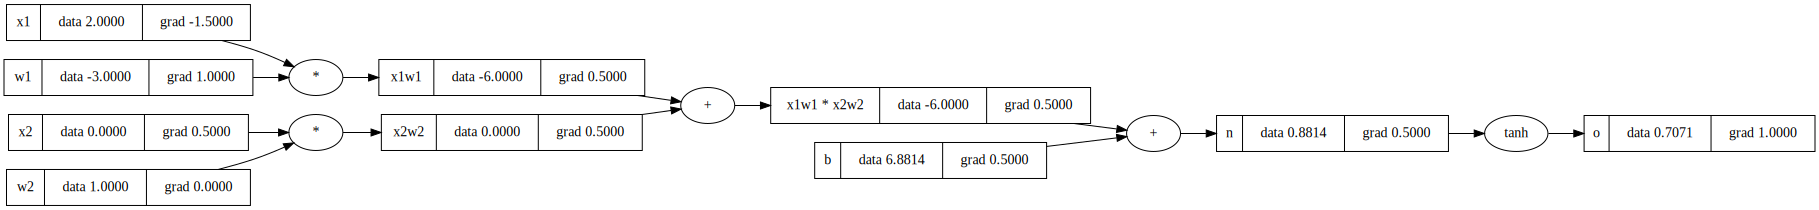

In [128]:
draw_dot(o)

In [123]:
o.backward()